<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_going-deeper/01_nlp/GD-02/%5BGD-02%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 02 : 멋진 단어사전 만들기**

---

# 1. SentencePiece 사용하기

## 1-1. 데이터 준비

### 1-1-1. 라이브러리 Import

In [ ]:
import os
import re
import konlpy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm

from konlpy.tag import Kkma
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

### 1-1-2. 데이터 Import

In [ ]:
train_data = pd.read_table('C:/Users/96452/00_work/NLP-02/data/ratings_train.txt')
test_data = pd.read_table('C:/Users/96452/00_work/NLP-02/data/ratings_test.txt')
temp_data = 'C:/Users/96452/00_work/NLP-02/data/korean-english-park.train.ko.temp'

## 1-2. 데이터 형태 확인

### 1-2-1. 기본 데이터 형태 확인

- **train_data 데이터 확인**  

    **데이터 수**  
    총 15,000개
    
    **컬럼 수**  
    총 3개 (id, document, label)  

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


- **test_data 데이터 확인**  

    **데이터 수**  
    총 5,000개
    
    **컬럼 수**  
    총 3개 (id, document, label)  

In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


## 1-3. 전처리 진행

### 1-3-1. 정규식

- **train_data 정규화 (문자, 숫자, 공백을 제외한 나머지 제거)**

In [ ]:
train_data['document'] = train_data['document'].str.replace(pat=r'[^가-힣0-9a-zA-Z ]+', repl= r'', regex=True)

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


- **test_data 정규화 (문자, 숫자, 공백을 제외한 나머지 제거)**

In [ ]:
test_data['document'] = test_data['document'].str.replace(pat=r'[^가-힣0-9a-zA-Z ]+', repl= r'', regex=True)

In [ ]:
test_data

,id,document,label
0,6270596,굳,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


### 1-3-2. 결측치 및 중복 데이터 제거

- **train_data 결측치 및 중복 데이터 확인**

In [ ]:
print('train_data 데이터 수:', len(train_data))    
print('train_data 중복 데이터 수:', train_data.duplicated().sum())
print('train_data null 값:\n', train_data.isnull().sum())

train_data 데이터 수: 150000
train_data 중복 데이터 수: 0
train_data null 값:
 id          0
document    5
label       0
dtype: int64


- **train_data 결측치 및 중복 데이터 제거**

In [ ]:
train_data.dropna(inplace=True)
train_data.drop_duplicates(["document"], inplace=True)

print('train_data 데이터 수:', len(train_data))    
print('train_data 중복 데이터 수:', train_data.duplicated().sum())
print('train_data null 값:\n', train_data.isnull().sum())

train_data 데이터 수: 143899
train_data 중복 데이터 수: 0
train_data null 값:
 id          0
document    0
label       0
dtype: int64


- **train_data 결측치 및 중복 데이터 제거 후 데이터 확인**

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요,1
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


- **test_data 결측치 및 중복 데이터 확인**

In [ ]:
print('test_data 데이터 수:', len(test_data))    
print('test_data 중복 데이터 수:', test_data.duplicated().sum())
print('test_data null 값:\n', test_data.isnull().sum())

test_data 데이터 수: 50000
test_data 중복 데이터 수: 0
test_data null 값:
 id          0
document    3
label       0
dtype: int64


- **test_data 결측치 및 중복 데이터 제거**

In [ ]:
test_data.dropna(inplace=True)
test_data.drop_duplicates(["document"], inplace=True)

print('test_data 데이터 수:', len(test_data))    
print('test_data 중복 데이터 수:', test_data.duplicated().sum())
print('test_data null 값:\n', test_data.isnull().sum())

test_data 데이터 수: 48552
test_data 중복 데이터 수: 0
test_data null 값:
 id          0
document    0
label       0
dtype: int64


- **test_data 결측치 및 중복 데이터 제거 후 데이터 확인**

In [ ]:
test_data

,id,document,label
0,6270596,굳,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


### 1-3-3. 데이터 분포 길이 조정

- **데이터 분포 길이 확인 및 시각화 함수**

In [ ]:
def draw_sentence_length(data, title):
    min_len = 999
    max_len = 0
    sum_len = 0
    
    data = data.dropna()
    cleaned_corpus = list(set(data))
    
    for sen in cleaned_corpus:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length
        
    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in cleaned_corpus:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(title)
    plt.show()
    
    print("전체 문장 수:", len(cleaned_corpus))
    print("최단 문장 길이:", min_len)
    print("최장 문장 길이:", max_len)
    print("평균 문장 길이:", sum_len // len(cleaned_corpus))

- **train_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_14536\4069133019.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


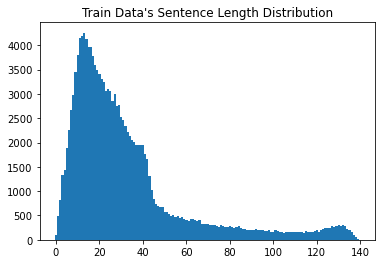

전체 문장 수: 143899
최단 문장 길이: 1
최장 문장 길이: 140
평균 문장 길이: 33


In [ ]:
draw_sentence_length(train_data["document"], title="Train Data's Sentence Length Distribution")

- **test_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_14536\4069133019.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


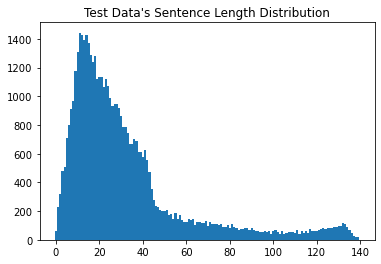

전체 문장 수: 48552
최단 문장 길이: 1
최장 문장 길이: 140
평균 문장 길이: 33


In [ ]:
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

- **최적의 max_len 탐색 함수**

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

- **train_data 최적의 max_len 확인**  

In [ ]:
below_threshold_len(105, train_data["document"])
below_threshold_len(100, train_data["document"]) 
below_threshold_len(10, train_data["document"])
below_threshold_len(7, train_data["document"])

전체 샘플 중 길이가 105 이하인 샘플의 비율: 95.3390920020292
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.74284046449246
전체 샘플 중 길이가 10 이하인 샘플의 비율: 12.120306603937484
전체 샘플 중 길이가 7 이하인 샘플의 비율: 5.792952001056297


- **test_data 최적의 max_len 확인**

In [ ]:
below_threshold_len(105, test_data["document"])
below_threshold_len(100, test_data["document"]) 
below_threshold_len(10, test_data["document"])
below_threshold_len(7, test_data["document"])

전체 샘플 중 길이가 105 이하인 샘플의 비율: 95.29164607019278
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.70670621189652
전체 샘플 중 길이가 10 이하인 샘플의 비율: 12.664771791069368
전체 샘플 중 길이가 7 이하인 샘플의 비율: 6.380787609161312


- **train_data, test_data 데이터 분포 길이 조정 함수**  
test_data와 train_data의 상위 5%, 하위 5% 정도를 제거한 범위인 7 - 105 범위의 데이터만 사용

In [ ]:
def filt_length(data, min_len, max_len):
    df = train_data.copy()
    df["length"] = df["document"].apply(lambda x: len(x))
    
    df = df.loc[df["length"] >= min_len]
    df = df.loc[df["length"] <= max_len]
    
    df.drop(["length"], axis="columns", inplace=True)
    return df

- **train_data, test_data 데이터 분포 길이 조정**  
test_data와 train_data의 상위 5%, 하위 5% 정도를 제거한 범위인 7 - 105 범위의 데이터만 사용

In [ ]:
min_len, max_len = 7, 105

train_data = filt_length(train_data, min_len=min_len, max_len = max_len)
test_data = filt_length(test_data, min_len=min_len, max_len = max_len)

y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

- **데이터 분포 조정 후 train_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_14536\4069133019.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


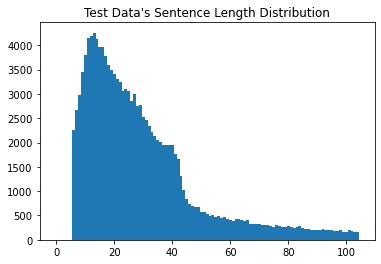

전체 문장 수: 131115
최단 문장 길이: 8
최장 문장 길이: 105
평균 문장 길이: 30


In [ ]:
draw_sentence_length(train_data["document"], title="Test Data's Sentence Length Distribution")

C:\Users\96452\AppData\Local\Temp\ipykernel_14536\4069133019.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


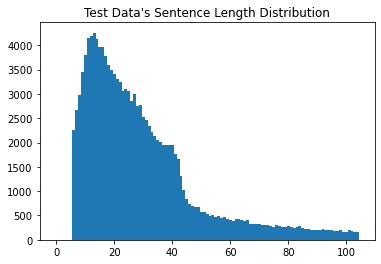

전체 문장 수: 131115
최단 문장 길이: 8
최장 문장 길이: 105
평균 문장 길이: 30


In [ ]:
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

---

## 1-2. 토큰화

### 1-2-1. 공백 기반 토큰화

- **공백 기준 토큰화 함수**

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

def get_split_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(sentence.split())

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

- **단어 사전 크기 확인**

In [ ]:
X_train = get_split_tokenize(train_data["document"])
split_X_test = get_split_tokenize(test_data["document"])

print("단어 사전 크기:", len(tokenizer.word_index))

단어 사전 크기: 254261


- **데이터 분할**

In [ ]:
split_train_input, split_val_input, split_train_target, split_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2525)

### 1-2-2. Kkma을 활용한 형태소 기반 토큰화

- **Kkma 토큰화 함수**

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
m = Kkma()

def get_Kkma_tokenize(data):
    Kkma_corpus = []
    
    for sentence in data:
        Kkma_corpus.append(m.morphs(sentence))

    tokenizer.fit_on_texts(Kkma_corpus)
    Kkma_tensor = tokenizer.texts_to_sequences(Kkma_corpus)
    Kkma_tensor = tf.keras.preprocessing.sequence.pad_sequences(Kkma_tensor, padding='post', maxlen = max_len)
    return Kkma_tensor

- **단어 사전 크기 확인**

In [ ]:
X_train = get_Kkma_tokenize(train_data["document"])
Kkma_X_test = get_Kkma_tokenize(test_data["document"])

print("단어 사전 크기:", len(tokenizer.word_index))

- **데이터 분할**

In [ ]:
Kkma_train_input, Kkma_val_input, Kkma_train_target, Kkma_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2525)

### 1-2-3. SentencePiece 기반 토큰화

- **entencePiece 토큰화 함수**

In [ ]:
vocab_size = 8000

with open(temp_data, 'w') as f:
    for row in cut_clean_data['document']:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_data, vocab_size)    
)

In [ ]:
def tokenize(s, corpus):
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("C:/Users/96452/00_work/NLP-02/korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('./korean_spm.model')

- **데이터 분할**

In [ ]:
X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
sp_X_test, X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

sp_train_input, sp_val_input, sp_train_target, sp_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2525)

---

## 1-3. 모델 설계 및 학습

---

# 2. 회고

---

# 3. 참고 목록